Remise électronique sur ZoneCours au plus tard le **22 février à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées.
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **40%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des graphiques
* **15%** Clarté du code (.py)

Dans les tables, présentez 4 décimales après le point.

# Question 1

Une action ne versant pas de dividende cote présentement à 100. Le taux sans risque à 1 mois est de 5%. Vous observez sur le marché les prix suivants pour des puts européens venant à maturité dans 1 mois:


In [227]:
import utils as f
import numpy as np
from typing import Tuple, Any, Iterable
import pandas as pd
from numpy import ndarray
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import seaborn

import importlib
importlib.reload(f)

# use 4 decimals for tables
pd.options.display.float_format = '{:,.4f}'.format

In [228]:
info = f.get_info()
info

,Strike,Put
0,80.0000,0.1900
1,90.0000,0.6907
2,97.5000,1.6529
3,102.5000,3.3409
4,110.0000,9.8399
5,120.0000,19.5805


Quelles sont les volatilités implicites ('IV') de ces puts? Tracez le graphe des ces IV en fonction de $K/S$ et discutez brièvement.


On commence par poser les données du problème :

- Le sous-jacent qui ne verse pas de dividendes côte actuellement à 100$
- Expiration du put option dans un mois, c'est-à-dire 1/12 d'année.
- Taux sans risque à un mois est de 5%

In [229]:
S0 = 100.0
T = 1/12
r = 0.05 

Avant de pouvoir trouver les volatilités implicites ("IV") de ces puts, nous devons définir le modèle de Black-Merton-Scholes pour un put.

In [230]:
f.compute_put_option(sigma=0.2, S0=S0, K=102.5, T=T, r=r)

6.679222822477925

In [231]:
sigma = f.compute_implied_volatility_by_bisection(S0=S0, K=102.5, T=T, r=r, Put=3.3409)

In [232]:
f.compute_put_option(sigma=sigma, S0=S0, K=102.5, T=T, r=r)

3.3409000008688565

In [233]:
results = pd.DataFrame()

In [234]:
results["Sigma"] = f.compute_implicit_vol_array(S0=S0, K=info['Strike'].values, T=T, r=r, Put=info['Put'].values)

In [235]:
results["Put BMS"] = f.compute_put_option(sigma=results["Sigma"].values, S0=S0, K=info['Strike'].values, T=T, r=r)
results["Put"] = info['Put']

In [236]:
results["Error"] = results["Put BMS"] - results["Put"]
results

,Sigma,Put BMS,Put,Error
0,0.1520,0.1900,0.1900,0.0000
1,0.1306,0.6907,0.6907,-0.0000
2,0.1133,1.6529,1.6529,-0.0000
3,0.1138,3.3409,3.3409,0.0000
4,0.1788,9.8399,9.8399,0.0000
5,0.2610,19.5805,19.5805,-0.0000


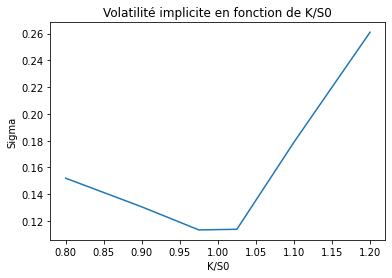

In [237]:
results["K/S0"] = info['Strike']/S0

plt.plot(results["K/S0"], results['Sigma'])
plt.xlabel("K/S0")
plt.ylabel("Sigma")
plt.title("Volatilité implicite en fonction de K/S0")
plt.show()

In [238]:
S0 = 100

In [239]:
f.CRR_Tree(S0=S0, K=info['Strike'].iloc[1], T=T, r=r, sigma=results['Sigma'].iloc[1], N=400)

0.6897323256648814

In [240]:
f.CRR_Tree_adjusted(S0=S0, K=info['Strike'].iloc[1], T=T, r=r, sigma=results['Sigma'].iloc[1], N=400)

0.6909660467350047

# Question 2

Vous vous intéressez à ces options parce que vous avez, d'autre part,
émis des produits structurés contenant des puts de même strikes, mais permettant un exercice à tout moment d'ici la maturité. Pour chacun de ces strike, vous désirez donc utiliser un arbre CRR afin de valoriser l'option américaine correspondante.

En premier lieu, vous désirez donc étudier la convergence de votre arbre vers le prix BMS pour les européennes observées sur le marché. Pour des valeurs de $N$ allant de 2 à 100 (`range(2,101)`), tracer, dans une figure
`
    fig, axes = plt.subplots(3, 2, figsize=(15,20))
`
avec une sous-figure par strike,

* Le prix CRR obtenu pour chaque $N$
* Une ligne horizontale traitillée au prix de marché
* Deux ligne horizontales pointillées à $\pm$1 bp du prix de marché

Discutez brièvement de la qualité de la convergence.

In [241]:
f.CRR_Tree(S0=S0, K=info['Strike'].iloc[1], T=T, r=r, sigma=results['Sigma'].iloc[1], N=100)

0.6853351293252177

In [242]:
N_range = np.arange(5, 101)

In [244]:
df_crr = f.compute_crr_tree_puts_df(S0=S0, K=info['Strike'], T=T, r=r, sigma=results['Sigma'], N_range=N_range)


In [245]:
df_crr.tail()

,Put_0,Put_1,Put_2,Put_3,Put_4,Put_5
96,0.1890,0.6859,1.6485,3.3319,9.8516,19.5969
97,0.1904,0.6958,1.6600,3.3486,9.8324,19.5598
98,0.1899,0.6840,1.6492,3.3329,9.8504,19.5975
99,0.1896,0.6957,1.6597,3.3483,9.8353,19.5537
100,0.1906,0.6853,1.6499,3.3339,9.8490,19.5976


In [246]:
info["Put"]

0    0.1900
1    0.6907
2    1.6529
3    3.3409
4    9.8399
5   19.5805
Name: Put, dtype: float64

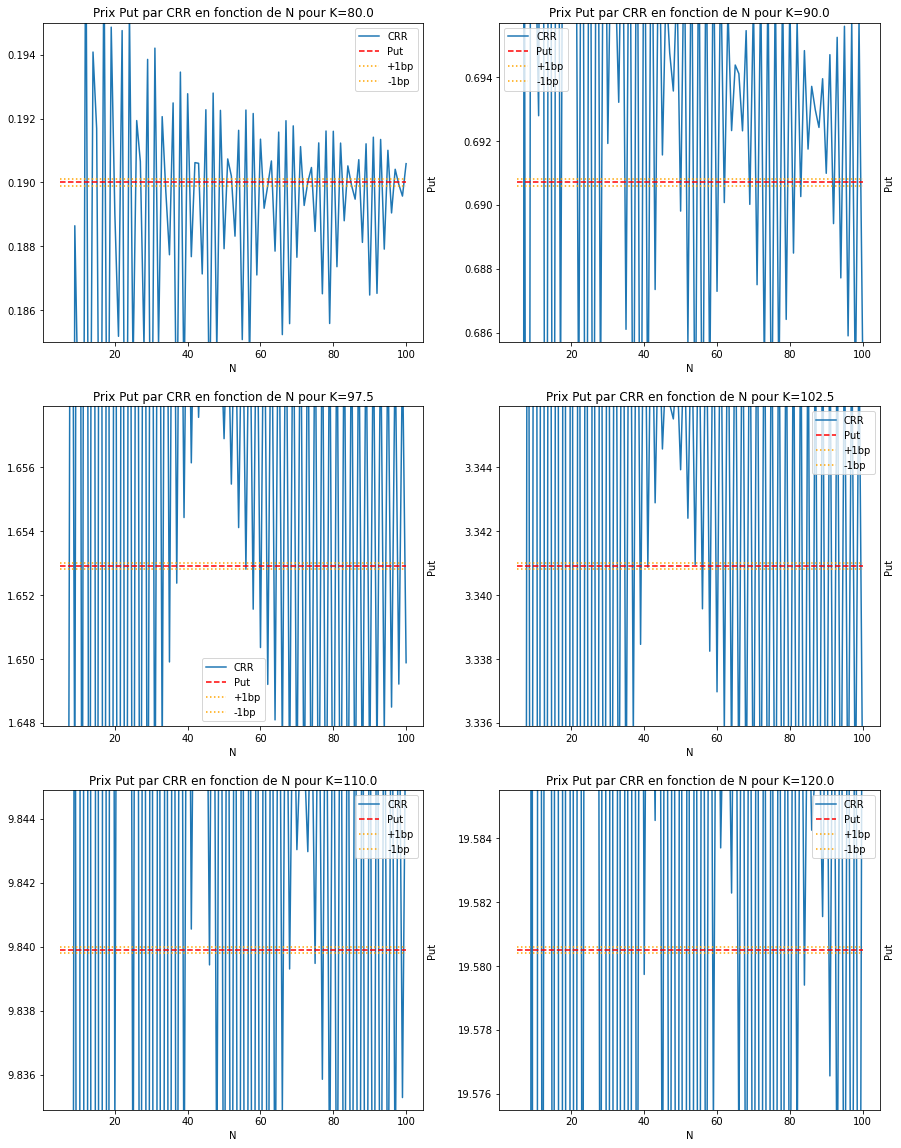

In [247]:
f.plot_crr_tree_puts(S0=S0, K=info['Strike'], T=T, r=r, sigma=results['Sigma'], N_range=N_range, zoom_factor=50)

# Question 3

Répétez la figure ci-haut, en vous concentrant sur les pas $N = range(400, 501)$.
Ajoutez aussi, pour chaque strike, une courbe raportant la valeur obtenu à $N$ avec l'arbre CRR ajusté à l'aide de la correction de Broadie et Detemple. Comparez les deux méthodes. En particulier, soulignez l'avantage de l'ajustement quand viendra le temps de choisir un nombre de pas de temps respectant une tolérance de $\pm$1bp.

In [249]:
N_range = np.arange(400, 501)

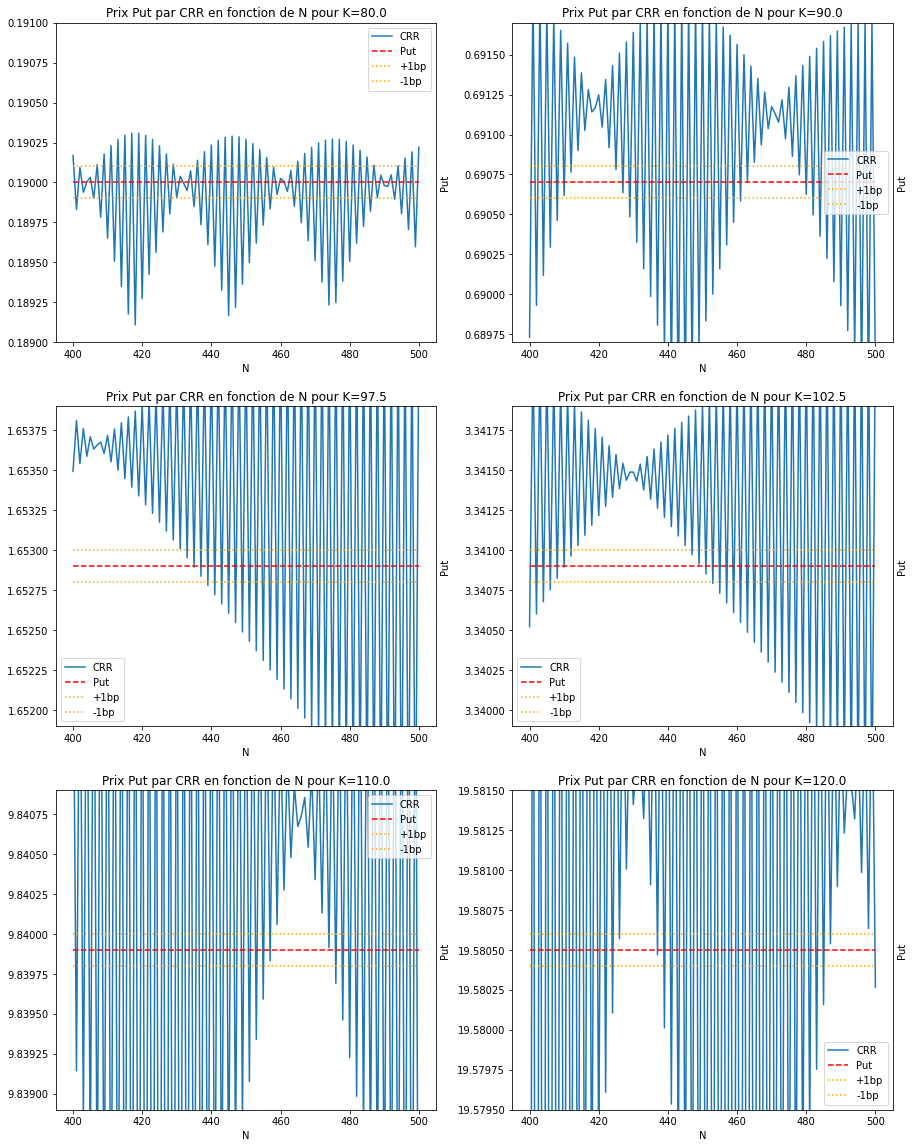

In [250]:
f.plot_crr_tree_puts(S0=S0, K=info['Strike'], T=T, r=r, sigma=results['Sigma'], N_range=N_range, zoom_factor=50)

In [251]:
f.compute_crr_tree_puts_adj_df(S0=S0, K=info['Strike'], T=T, r=r, sigma=results['Sigma'], N_range=N_range).tail()

,Put_0,Put_1,Put_2,Put_3,Put_4,Put_5
496,0.1899,0.6909,1.6532,3.3410,9.8401,19.5807
497,0.1899,0.6909,1.6532,3.3410,9.8401,19.5807
498,0.1899,0.6909,1.6532,3.3410,9.8401,19.5807
499,0.1899,0.6909,1.6532,3.3410,9.8401,19.5807
500,0.1899,0.6909,1.6532,3.3410,9.8401,19.5807


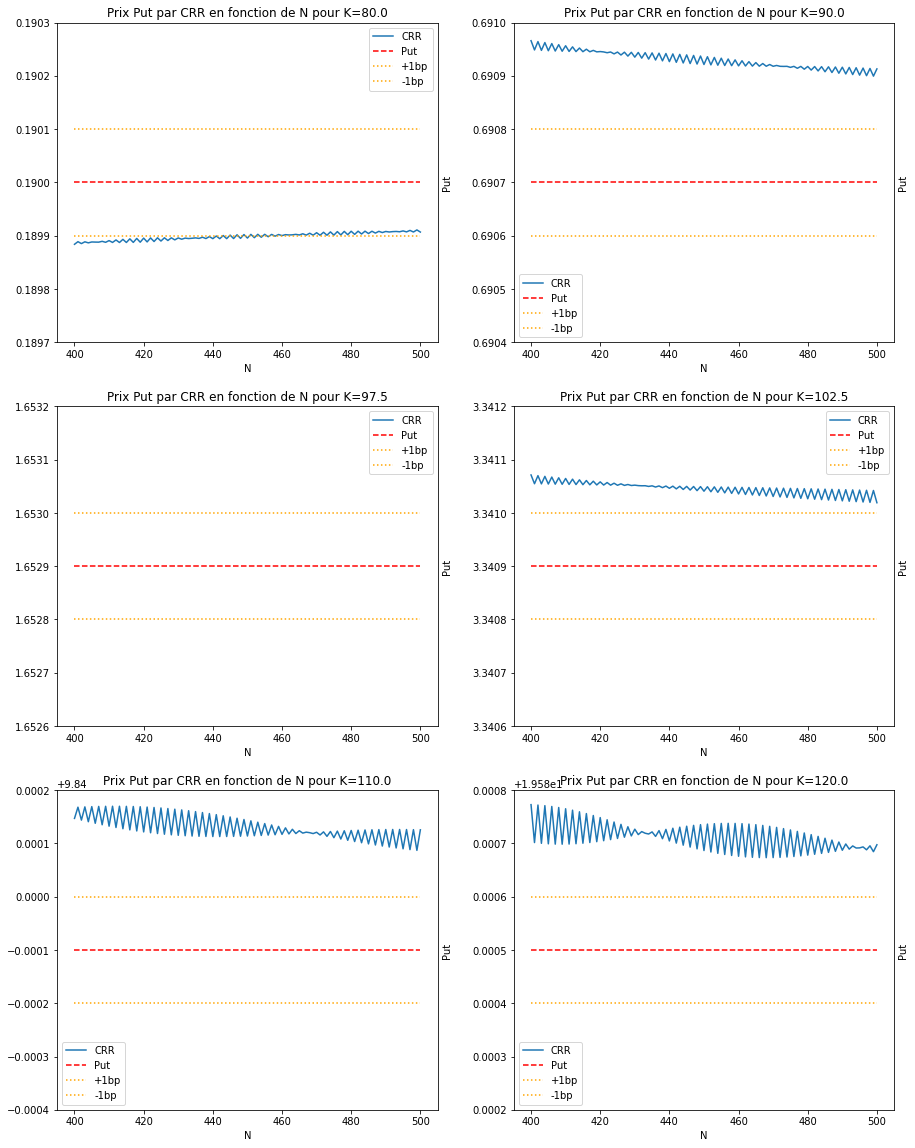

In [254]:
f.plot_crr_tree_puts_adj(S0=S0, K=info['Strike'], T=T, r=r, sigma=results['Sigma'], N_range=N_range, zoom_factor=3)

# Question 4

En utilisant maintenant que les pas $N = range(500, 3001, 100)$, n'utilisez que l'arbre avec ajustement. Tracez à nouveau une figure de convergence 3x2. Combien de pas de temps sont nécessaires pour que tous les strikes respectent une tolérance de $\pm$1bp?

Assurez-vous aussi, pour chaque $N$, de calculer les 3 approximations suivantes du gamma:
\begin{align}
 \Gamma_0 &= \frac{p_{uu}-2p_{ud}+p_{dd}}{\left[(u-d) S\right]^{2}},
 \\
 \Gamma_1 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S}
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{Su - Sd},
 \\
 \Gamma_2 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S}
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{\frac{1}{2}(Su^2 - Sd^2)}.
\end{align}

Produisez une nouvelle figure de convergence, cette fois vers $\Gamma_{BMS}\pm 1bp$. Discutez brièvement.


# Question 5
Soit $N^*$ le nombre de pas de temps nécessaire à une convergence pour les 6 strikes (cf. Question 4). Ajoutez à la table dans l'énoncé de la Question 1 les colonnes suivantes:

`
colnames = ['IV','Amer','EarlyEx','Gamma_e','Gamma_a','Gamma_ex']
`

qui contiendront pour chaque strike, respectivement, la volatilité implicite (en Q1), la valeur de l'américaine, la prime associée à l'exercice anticipé et le gamma de l'européenne (BMS) et de l'américaine, et la différence entre les gammas.

Discutez.